## Unsupervised learning: K-means cluster 
- We apply K-means clustering to identify any distinct clusters that may correlate to fraudulent job listings within the previously cleaned textual data

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

df = pd.read_csv('../dataset/k-means_dataset.csv')

# Select all numerical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Normalize the dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_columns])

## Apply PCA and plot for visualisation

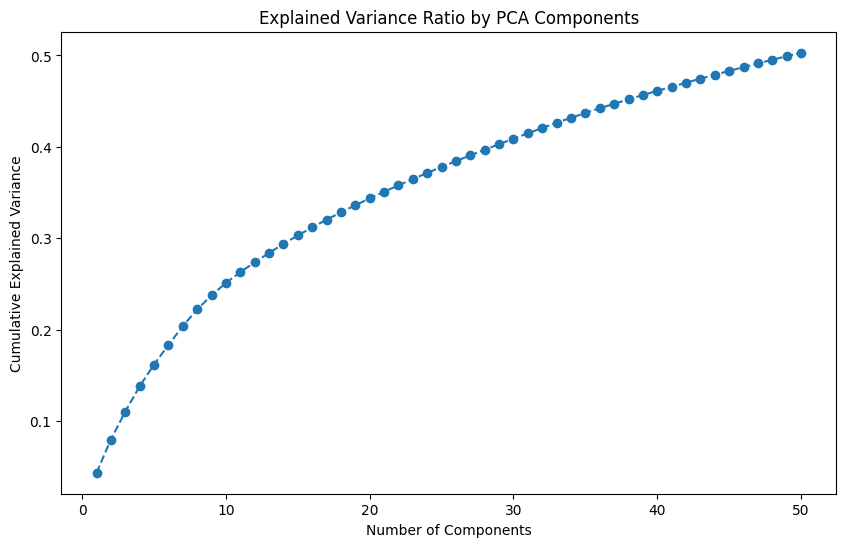

In [2]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=50, random_state=42)  # Reduce to 50 principal components
reduced_data = pca.fit_transform(scaled_data)

# Plot explained variance ratio to understand how much information is retained
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title("Explained Variance Ratio by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

## Apply K-means clustering on the cleaned data

In [14]:
# Apply K-means clustering on PCA-reduced data
kmeans = KMeans(n_clusters=2, random_state=42)  # Adjust the number of clusters as needed
kmeans.fit(reduced_data)

# Assign cluster labels to the original dataset
df['cluster'] = kmeans.labels_

## Visualise Data in 2d
- From the plot, we can see that clusters are not well separated.
- We shall use Silhouette score to determine the optimal number of clusters

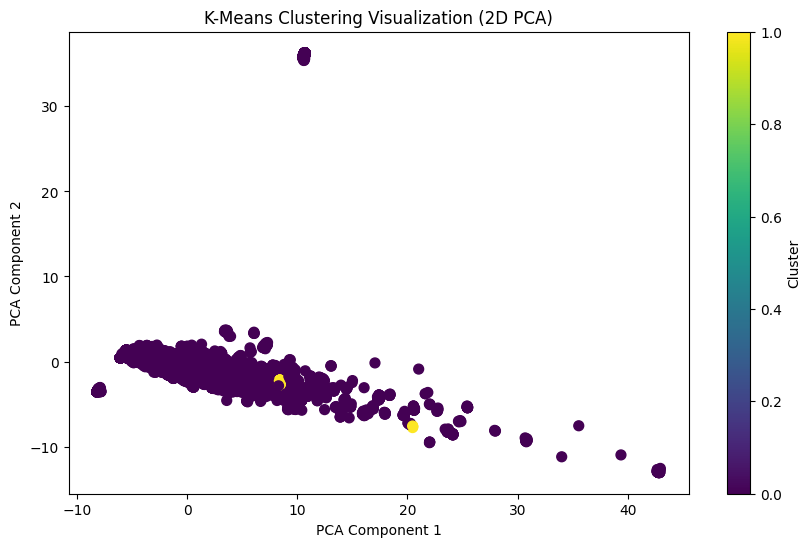

In [15]:
# Reduce to 2 dimensions for visualization
pca_2d = PCA(n_components=2, random_state=42)
reduced_data_2d = pca_2d.fit_transform(scaled_data)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.title("K-Means Clustering Visualization (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


## Test for optimal no. of clusters
- From the plot, we can see that 97 has the best score (apart from 2)
- Despite 2 having a silhouette score > 0.5, we want to avoid using 2 clusters as we might lose meaningful subgroups

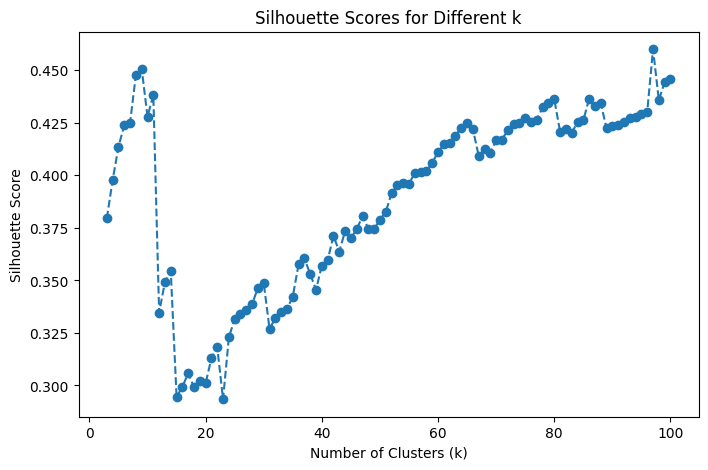

Highest Silhouette Score: 0.4600413459930194
Optimal number of clusters (k): 97


In [17]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

#From previous testing we know k = 2 has a silhouette score > 0.5 but with 2 clusters we might lose meaningful subgroups

silhouette_scores = []
k_values = range(3, 101)  # Test k from 3 to 100

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)  # Use PCA-reduced data or scaled data
    score = silhouette_score(reduced_data, kmeans.labels_)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# Find the highest silhouette score and its corresponding k
max_score = max(silhouette_scores)
best_k = k_values[np.argmax(silhouette_scores)]

print(f"Highest Silhouette Score: {max_score}")
print(f"Optimal number of clusters (k): {best_k}")


## K-means clustering where n = 97

In [26]:
# Apply K-means clustering on PCA-reduced data
kmeans = KMeans(n_clusters=97, random_state=42)  # Adjust the number of clusters as needed
kmeans.fit(reduced_data)

# Assign cluster labels to the original dataset
df['cluster'] = kmeans.labels_

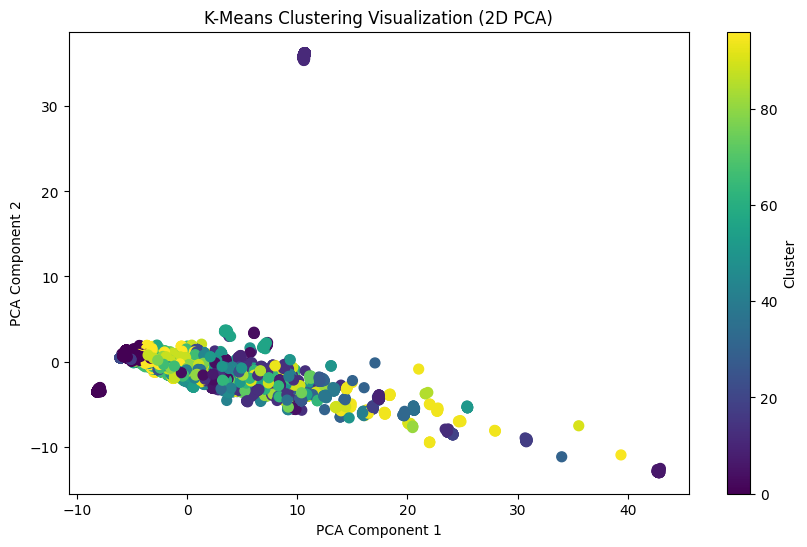

In [27]:
# Reduce to 2 dimensions for visualization
pca_2d = PCA(n_components=2, random_state=42)
reduced_data_2d = pca_2d.fit_transform(scaled_data)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.title("K-Means Clustering Visualization (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


## Analyse clusters for useful insights

In [28]:
# Group data by cluster and calculate fraud proportion
fraud_analysis = df.groupby('cluster')['fraudulent'].mean()
print(fraud_analysis)

# Count the total number of fraudulent and non-fraudulent jobs in each cluster
cluster_counts = df.groupby('cluster')['fraudulent'].value_counts()
print(cluster_counts)


cluster
0     0.147663
1     0.000000
2     0.000000
3     0.001362
4     0.000000
        ...   
92    0.000000
93    0.000000
94    0.000000
95    0.000000
96    0.018895
Name: fraudulent, Length: 97, dtype: float64
cluster  fraudulent
0        0             3446
         1              597
1        0              574
2        0               75
3        0              733
                       ... 
93       0               29
94       0               78
95       0               18
96       0              675
         1               13
Name: count, Length: 108, dtype: int64


Clusters with fraudulent listings: [0, 3, 13, 37, 42, 50, 57, 66, 77, 80, 88, 96]
Original number of rows: 17880
Filtered number of rows: 10193


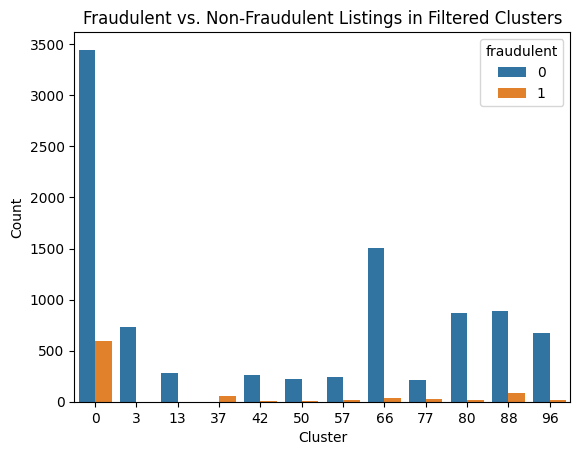

In [31]:
# Identify clusters with no fraudulent listings
clusters_with_fraud = df.groupby('cluster')['fraudulent'].sum()
clusters_with_fraud = clusters_with_fraud[clusters_with_fraud > 0].index  # Clusters with fraud

print("Clusters with fraudulent listings:", clusters_with_fraud.tolist())

# Filter the dataset to include only clusters with fraudulent listings
filtered_df = df[df['cluster'].isin(clusters_with_fraud)]

print(f"Original number of rows: {len(df)}")
print(f"Filtered number of rows: {len(filtered_df)}")

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the number of fraudulent vs. non-fraudulent jobs in the remaining clusters
sns.countplot(data=filtered_df, x='cluster', hue='fraudulent')
plt.title('Fraudulent vs. Non-Fraudulent Listings in Filtered Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()



## Evaluate using Precision,Recall and F1-scores

In [32]:
from sklearn.metrics import classification_report

# Map clusters to the majority fraud class (1 or 0) for evaluation
cluster_fraud_labels = df.groupby('cluster')['fraudulent'].apply(lambda x: x.mode()[0])
df['predicted_fraud'] = df['cluster'].map(cluster_fraud_labels)

# Evaluate predictions against the true 'fraudulent' labels
print(classification_report(df['fraudulent'], df['predicted_fraud']))


              precision    recall  f1-score   support

           0       0.95      1.00      0.98     17014
           1       1.00      0.06      0.12       866

    accuracy                           0.95     17880
   macro avg       0.98      0.53      0.55     17880
weighted avg       0.96      0.95      0.94     17880

